In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard
from keras.datasets import imdb
import tensorflow as tf
import datetime

## Load Dataset- IMDB
The IMDB dataset is a collection of 50,000 movie reviews from the Internet Movie Database (IMDB) that have been preprocessed and labeled by sentiment (positive/negative). The dataset is split into 25,000 reviews for training and 25,000 reviews for testing. Reviews have been preprocessed, and each review is encoded as a list of word indexes (integers).

**Desired Output:** Using RNN, we will process each word in a movie review sequentially and predict whether the review is positive or negative.

In [3]:
# Parameters
max_vocab = 10000  # Top 10,000 words
max_length = 200   # Max review length

# Load data
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=max_vocab)


**NOTE:** num_words=10000 means that only the top 10,000 most frequent words will be kept in the dataset.

In [5]:
X_train.shape

(25000,)

In [6]:
y_train.shape

(25000,)

In [7]:
X_test.shape

(25000,)

In [8]:
y_test.shape

(25000,)

In [9]:
X_train[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 2,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 2,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 2,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 2,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 2,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 2,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5,
 144,
 30,
 5535,
 18,

In [10]:
y_train[0:99]

array([1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1])

### **Preprocess data**

**Preprocessing the Data for the Neural Network**:

* max_vocab = 10000: This line sets 
the maximum vocabulary size to 10,000 words. This means that only the 10,000 most frequent words in the dataset will be considered, and less common words will be ignored.

* max_length = 200: This line sets the maximum length of a review to 200 words. Reviews longer than 200 words will be truncated, and shorter reviews will be padded.

* X_train and X_test contain the movie reviews themselves (represented as sequences of word indices) as seen above.

* y_train and y_test will contain the corresponding sentiment labels (0 for negative, 1 for positive).

* pad_sequences function is used such that it takes X_train and X_test (the movie review sequences) and pads or truncates them to ensure they all have a length of max_length (200 words in this case). If a review is shorter than 200 words, it will be padded with zeros at the beginning to reach the desired length. If a review is longer than 200 words, it keeps the first 200 words only.

In summary, the code below preprocesses the IMDB movie review data to make it suitable for input to a Recurrent Neural Network (RNN). It limits the vocabulary size, ensures all reviews have the same length, and prepares the data for training and testing.

In [12]:
from keras.preprocessing.sequence import pad_sequences

# Pad sequences to ensure equal length
X_train = pad_sequences(X_train, maxlen=max_length)
X_test = pad_sequences(X_test, maxlen=max_length)

print(f"Training data shape: {X_train.shape}, Test data shape: {X_test.shape}")

Training data shape: (25000, 200), Test data shape: (25000, 200)


## Model Design
* Embedding: Used for representing words (or tokens) as dense vectors in a lower-dimensional space. It is essential for Natural Language Processing (NLP) tasks for dimensionality reduction as well as capturing semantic relationships between the provided words snce similar words are assigned similar representations.
* LSTM: Core building blocks for creating sequential models. A recurrent layer with Long Short-Term Memory, which helps capture long-term dependencies in data sequences and avoid vanishing or exploding gradient proe 
* Dense: A fully connected neural network layer with a single output neuron, crucial for transforming the learned features into a format suitable for making predictions.

In [14]:
from keras.layers import Embedding, SimpleRNN, Dense, LSTM
from keras.optimizers import Adam, SGD
import matplotlib.pyplot as plt

model = Sequential()
model.add(Embedding(input_dim=max_vocab, output_dim=128))
model.add(LSTM(64, return_sequences=True, activation='relu'))  # Layer 1
model.add(LSTM(32, return_sequences=True, activation='relu'))  # Layer 2
model.add(LSTM(16, activation='relu'))                         # Layer 3
model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

In [15]:
#After processing
X_train[0]

array([   5,   25,  100,   43,  838,  112,   50,  670,    2,    9,   35,
        480,  284,    5,  150,    4,  172,  112,  167,    2,  336,  385,
         39,    4,  172, 4536, 1111,   17,  546,   38,   13,  447,    4,
        192,   50,   16,    6,  147, 2025,   19,   14,   22,    4, 1920,
       4613,  469,    4,   22,   71,   87,   12,   16,   43,  530,   38,
         76,   15,   13, 1247,    4,   22,   17,  515,   17,   12,   16,
        626,   18,    2,    5,   62,  386,   12,    8,  316,    8,  106,
          5,    4, 2223, 5244,   16,  480,   66, 3785,   33,    4,  130,
         12,   16,   38,  619,    5,   25,  124,   51,   36,  135,   48,
         25, 1415,   33,    6,   22,   12,  215,   28,   77,   52,    5,
         14,  407,   16,   82,    2,    8,    4,  107,  117, 5952,   15,
        256,    4,    2,    7, 3766,    5,  723,   36,   71,   43,  530,
        476,   26,  400,  317,   46,    7,    4,    2, 1029,   13,  104,
         88,    4,  381,   15,  297,   98,   32, 20

In [16]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Model 1 Training

In [18]:
model.fit(
        X_train, y_train, 
        validation_split=0.2, 
        epochs=10, 
        batch_size=128,
        verbose=1
    )

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 31s 190ms/step - accuracy: 0.5237 - loss: 86.2470 - val_accuracy: 0.6412 - val_loss: 0.6727
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 31s 201ms/step - accuracy: 0.7152 - loss: 16854.9941 - val_accuracy: 0.7268 - val_loss: 175075.6406
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 33s 207ms/step - accuracy: 0.7052 - loss: 2137212928.0000 - val_accuracy: 0.5062 - val_loss: 0.6957
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 33s 211ms/step - accuracy: 0.4964 - loss: 0.6959 - val_accuracy: 0.5062 - val_loss: 0.6927
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 33s 209ms/step - accuracy: 0.4912 - loss: 0.6935 - val_accuracy: 0.5068 - val_loss: 0.6921
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 34s 214ms/step - accuracy: 0.5079 - loss: 0.6919 - val_accuracy: 0.5358 - val_loss: 0.6920
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 35s 223ms/step - accuracy: 0.5499 - loss: 0.6917 - val_accuracy: 0.6582 - val_loss: 0.6919
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 35s 225ms/step - accurac

### Model 1 Performance
Model 1, using relu activation for the LSTM layers had several issues in training the imdb sentiment analysis dataset. Some of the key issues are:
* The validation accuracy was much lower than training accuracy when the model performed best (epoch 4) which shows a very clear trend of overfitting
* The model performance drastically worsened after epoch 2, with the first sign being that the validation accuracy dropped to ~50% in epoch 3 and then training accuracy followed as well in all later epochs. This shows that the model had divergence, as also evidenced by the huge increase in the loss function value between epochs 2 and 3.

### Model 2 Training

In [21]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model.fit(
        X_train, y_train, 
        validation_split=0.2, 
        epochs=10, 
        batch_size=64,
        verbose=1,
        callbacks=[early_stopping]
    )

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 53s 168ms/step - accuracy: 0.6344 - loss: 0.6907 - val_accuracy: 0.5040 - val_loss: 0.6910
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 48s 152ms/step - accuracy: 0.5279 - loss: 0.6899 - val_accuracy: 0.6718 - val_loss: 0.6903
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 48s 153ms/step - accuracy: 0.7229 - loss: 0.6890 - val_accuracy: 0.6776 - val_loss: 0.6891
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 46s 148ms/step - accuracy: 0.7384 - loss: 0.6871 - val_accuracy: 0.6508 - val_loss: 0.6876
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 53s 168ms/step - accuracy: 0.7066 - loss: 0.6844 - val_accuracy: 0.6942 - val_loss: 0.6823
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 48s 154ms/step - accuracy: 0.7744 - loss: 0.6709 - val_accuracy: 0.7328 - val_loss: 0.6547
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 57s 181ms/step - accuracy: 0.7783 - loss: 0.6228 - val_accuracy: 0.7164 - val_loss: 0.5786
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 49s 157ms/step - accuracy: 0.7826 - loss: 0

### Model 2 Performance
Since Model 1 had an issue with overfitting, we attempted the same model with with a smaller batch size, which introduces the model to more noise during the training, but it was not very effective  in increasing overall model accuracy. However, we also introduced a callback called early stopping to avoid what happened in model 1 and to ensure that the best weights are kept. This fucntion looks to see if there is no improvement in validation loss after 3 epochs and then stops the model prematurely.
This is a sign that there is a bigger flaw in the model, and the activation fucntion relu is a prime suspect, since relu either zeroes out or holds on to the actual input value which means that it may be creating exploding gradients with long sequences during backpropagation. This is also observed with model 1 since the loss function minimizes at epoch 4 before massively rising afterwards. 

### Model 3 Training

In [24]:
model = Sequential()
model.add(Embedding(input_dim=max_vocab, output_dim=128))
model.add(LSTM(64, return_sequences=True, activation='tanh'))  # Layer 1
model.add(LSTM(32, return_sequences=True, activation='tanh'))  # Layer 2
model.add(LSTM(16, activation='tanh'))                         # Layer 3
model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(
        X_train, y_train, 
        validation_split=0.2, 
        epochs=10, 
        batch_size=64,
        verbose=1,
        callbacks=[early_stopping]
    )

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 47s 147ms/step - accuracy: 0.6955 - loss: 0.5484 - val_accuracy: 0.8428 - val_loss: 0.3896
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 47s 150ms/step - accuracy: 0.8898 - loss: 0.2846 - val_accuracy: 0.8686 - val_loss: 0.3537
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 52s 167ms/step - accuracy: 0.9341 - loss: 0.1866 - val_accuracy: 0.8612 - val_loss: 0.3631
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 53s 168ms/step - accuracy: 0.9609 - loss: 0.1155 - val_accuracy: 0.8614 - val_loss: 0.3864
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 48s 152ms/step - accuracy: 0.9754 - loss: 0.0831 - val_accuracy: 0.8544 - val_loss: 0.4161


### Model 3 Performance
Next, we attempted 'tanh' which is a more commonly used activation function with RNNs than relu, due to  its ability to generate an output between -1 and 1, that is centered around 0, which leads to faster convergence, as evidenced by a highly consistent validation accuracy from the first few epochs and avoids exploding gradients issues that were observed with relu. However, we also noticed that the training accuracy kept increasing substantially throughout epochs while validation remained constant, which means that the network was becoming prone to overfitting.

### Model 4 Training

In [27]:
model = Sequential()
model.add(Embedding(input_dim=max_vocab, output_dim=128))
model.add(LSTM(64, return_sequences=True, activation='tanh'))  # Layer 1
model.add(LSTM(32, return_sequences=True, activation='tanh'))  # Layer 2
model.add(LSTM(16, activation='tanh'))                         # Layer 3
model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(
        X_train, y_train, 
        validation_split=0.2, 
        epochs=10, 
        batch_size=32,
        verbose=1,
        callbacks=[early_stopping]
    )

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 51s 80ms/step - accuracy: 0.6985 - loss: 0.5408 - val_accuracy: 0.8486 - val_loss: 0.3502
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 47s 74ms/step - accuracy: 0.9021 - loss: 0.2558 - val_accuracy: 0.8716 - val_loss: 0.3082
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 46s 74ms/step - accuracy: 0.9304 - loss: 0.1894 - val_accuracy: 0.8732 - val_loss: 0.3300
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 47s 75ms/step - accuracy: 0.9638 - loss: 0.1124 - val_accuracy: 0.8570 - val_loss: 0.3751
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 49s 78ms/step - accuracy: 0.9763 - loss: 0.0757 - val_accuracy: 0.8604 - val_loss: 0.4183


### Model 4 Performance 
We attempted to further reduce the batch size to 32 from 64 reduce the overfitting issue observed in model 3, and it seemed to slightly help with training accuracy if the models are compared H2H per epoch, but the validation accuracy is mostly flat, so this reduction in batch size, which comes with an increase in computational complexity is not a highly effective tuning parameter in this case.


### Model 5 Training

In [30]:
from keras.layers import Dropout

model = Sequential()
model.add(Embedding(input_dim=max_vocab, output_dim=128))
model.add(LSTM(64, return_sequences=True, activation='tanh'))  # Layer 1
model.add(LSTM(32, return_sequences=True, activation='tanh'))  # Layer 2
model.add(LSTM(16, activation='tanh'))                         # Layer 3
model.add(Dropout(0.2)) # Dropout layer after the third LSTM Layer
model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(
        X_train, y_train, 
        validation_split=0.2, 
        epochs=10, 
        batch_size=32,
        verbose=1,
        callbacks=[early_stopping]
    )

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 48s 75ms/step - accuracy: 0.7086 - loss: 0.5532 - val_accuracy: 0.8408 - val_loss: 0.3791
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 47s 76ms/step - accuracy: 0.8859 - loss: 0.2966 - val_accuracy: 0.8754 - val_loss: 0.2979
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 47s 75ms/step - accuracy: 0.9263 - loss: 0.2007 - val_accuracy: 0.8606 - val_loss: 0.3351
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 47s 76ms/step - accuracy: 0.9521 - loss: 0.1428 - val_accuracy: 0.8686 - val_loss: 0.3766
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 45s 72ms/step - accuracy: 0.9584 - loss: 0.1248 - val_accuracy: 0.7934 - val_loss: 0.5074


### Model 5 Performance 
The introduction of a dropout layer after the 3rd LSTM layer as a regularization technique had a negligible impact on the outputs of the model in terms of validation accuracy. The next step will be to explore the use of sigmoid activation instead of tanh


### Model 6 Performance

In [33]:
model = Sequential()
model.add(Embedding(input_dim=max_vocab, output_dim=128))
model.add(LSTM(64, return_sequences=True, activation='sigmoid'))  # Layer 1
model.add(LSTM(32, return_sequences=True, activation='sigmoid'))  # Layer 2
model.add(LSTM(16, activation='sigmoid'))                         # Layer 3
model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(
        X_train, y_train, 
        validation_split=0.2, 
        epochs=10, 
        batch_size=64,
        verbose=1,
        callbacks=[early_stopping]
    )

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 47s 147ms/step - accuracy: 0.5283 - loss: 0.6820 - val_accuracy: 0.7760 - val_loss: 0.5046
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 45s 145ms/step - accuracy: 0.8128 - loss: 0.4485 - val_accuracy: 0.8144 - val_loss: 0.4321
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 47s 149ms/step - accuracy: 0.8858 - loss: 0.3074 - val_accuracy: 0.8362 - val_loss: 0.3973
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 44s 142ms/step - accuracy: 0.9122 - loss: 0.2443 - val_accuracy: 0.8492 - val_loss: 0.3592
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 44s 142ms/step - accuracy: 0.9387 - loss: 0.1865 - val_accuracy: 0.8650 - val_loss: 0.3576
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 45s 144ms/step - accuracy: 0.9504 - loss: 0.1538 - val_accuracy: 0.8554 - val_loss: 0.3831
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 45s 145ms/step - accuracy: 0.9599 - loss: 0.1344 - val_accuracy: 0.8614 - val_loss: 0.4031
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 45s 143ms/step - accuracy: 0.9653 - loss: 0

In [34]:
model.evaluate(X_test, y_test)

782/782 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.8521 - loss: 0.3762


[0.3718128204345703, 0.8541600108146667]

### Model 6 Performance
Using 'sigmoid' as an activation function led to very similar results when compared to 'tanh', both being substantially better than relu. This confirms that this model benefits from the non-linearity but also is prone to exploding gradients so its best to use functions that have the ability to squash the range of the output like sigmoid and tanh. Given the similarity in outcomes for all the models since model 2. We will consider the outcomes here 

### Model 7: Stronger Regularization and faster earlier stopping rate

In [37]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

model = Sequential()
model.add(Embedding(input_dim=max_vocab, output_dim=128))
model.add(LSTM(64, return_sequences=True, activation='sigmoid'))  # Layer 1
model.add(LSTM(32, return_sequences=True, activation='sigmoid'))  # Layer 2
model.add(LSTM(16, activation='sigmoid'))                         # Layer 3
model.add(Dropout(0.5)) # Dropout layer after the third LSTM Layer
model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history=model.fit(
        X_train, y_train, 
        validation_split=0.2, 
        epochs=10, 
        batch_size=32,
        verbose=1,
        callbacks=[early_stopping]
    )

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 46s 73ms/step - accuracy: 0.5265 - loss: 0.6901 - val_accuracy: 0.7258 - val_loss: 0.5603
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 44s 71ms/step - accuracy: 0.7916 - loss: 0.4996 - val_accuracy: 0.8434 - val_loss: 0.3897
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 46s 74ms/step - accuracy: 0.8769 - loss: 0.3411 - val_accuracy: 0.8540 - val_loss: 0.3610
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 45s 73ms/step - accuracy: 0.9184 - loss: 0.2522 - val_accuracy: 0.8570 - val_loss: 0.3517
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 45s 72ms/step - accuracy: 0.9322 - loss: 0.2103 - val_accuracy: 0.8476 - val_loss: 0.3643
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 45s 72ms/step - accuracy: 0.9489 - loss: 0.1800 - val_accuracy: 0.8520 - val_loss: 0.3906


In [38]:
model.evaluate(X_test, y_test)

782/782 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.8504 - loss: 0.3580


[0.35685208439826965, 0.8508399724960327]

### Accuracy and Evaluation

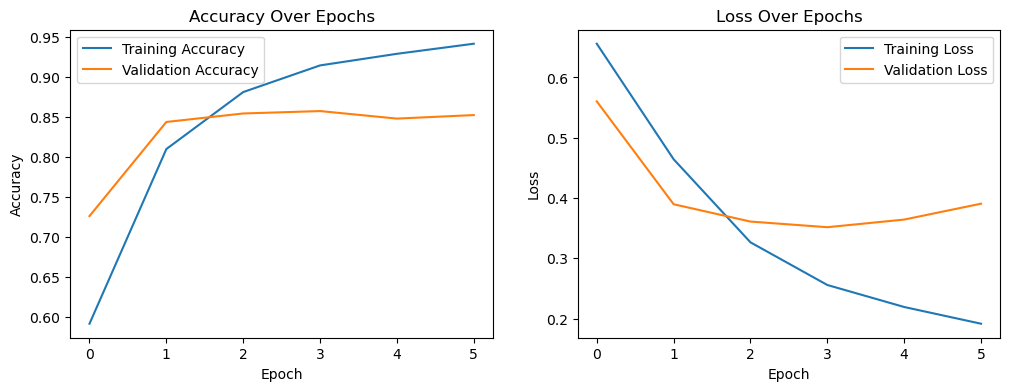

In [40]:
# Plot accuracy over epochs
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss over epochs
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


Despite several attempts to reduce overfitting, including tuning batch size, adjusting activation functions, adding drop out layers and experimenting with different rates. We see that our models had a tendency to overfit and plateau around 85-87% for validation and test accuracy, therefore, the use of the early callback with best weight restoration feature on was a good way to ensure that we are getting the best feaures out of whatever model we used. Moreover, we noticed that relu had a very poor performance likely due to exploding gradient issues due to the long text sequences that it was exposed to in this dataset.
Future work could involve, adapting learning rates, trying different optimizers and loss functions as well as using something like a tensorboard to further debug where the model falls short. However, per review of data and literature online, the test accuracy for the IMDB dataset tends to fall within 85-90% for a well-trained model, so the results we got here are satisfactory.